In [35]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from simulators.ricker import ricker
import utils.corruption as corruption
from itertools import permutations
from utils.metrics import *
import random
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def RMSE(gt, samples, p=1):
    if p == 1:
        dist = torch.mean(torch.abs(gt-samples))
    elif p == 2:
        dist = torch.sqrt(torch.mean((gt-samples)**2))
    elif p == 3:
        dist = torch.nn.functional.pairwise_distance(gt, samples, p=2).mean()
    else:
        dist = metrics.MMD_unweighted(samples, gt.reshape(-1, 2), lengthscale=metrics.median_heuristic(samples))
    return dist

In [15]:
x = torch.tensor(np.load("data/ricker_x_4000.npy")).reshape(4000, 100, 100).to(device)

theta = np.load("data/ricker_theta_4000.npy")

dataloader = DataLoader(x[:1000], batch_size=50, shuffle=True)

theta_gt = torch.tensor([4, 10])
obs = ricker(theta_gt)
sigma = torch.tensor(40)
obs_cont = corruption.magnitude_sigma(obs, var=sigma, length=100).reshape(-1, 100, 100).to(device)
print(obs_cont.shape)

torch.Size([1, 100, 100])


In [4]:
def regression_ABC(s_obs, param, sumStats, p):
    def mad(data):
        return np.mean(np.abs(data - np.mean(data, axis=0)), axis=0)

    if param.shape[0] < param.shape[1]:
        param = np.transpose(param)

    if sumStats.shape[0] < sumStats.shape[1]:
        sumStats = np.transpose(sumStats)
    
    M = len(param)
    M_epsilon = int(M*p)
    sumStats = sumStats
    s_obs = s_obs

    norm_factor = mad(sumStats)

    norm_sumStats = sumStats / norm_factor
    norm_s_obs = s_obs / norm_factor

    distance = np.linalg.norm(norm_sumStats - norm_s_obs, axis = 1)
    max_accepted_distance = np.sort(distance)[M_epsilon - 1]

    posterior_samples = param[distance <= max_accepted_distance, :]
    norm_sumStats_star = norm_sumStats[distance <= max_accepted_distance, :]

    weights = 1 - (distance[distance <= max_accepted_distance] / max_accepted_distance)**2
    W = np.diag(weights)

    s_obs_norm = np.tile(norm_s_obs, (M_epsilon,1))
    X = np.column_stack((np.ones(shape = (M_epsilon,1)), norm_sumStats_star - s_obs_norm))

    A = np.matmul(X.T, W)

    solution = np.linalg.solve(np.matmul(A, X), np.matmul(A, posterior_samples))

    beta = solution[1:,:]

    posterior_samples_adjusted = posterior_samples - np.matmul((norm_sumStats_star - s_obs_norm), beta)

    return posterior_samples_adjusted
    

In [5]:
class RickerSummary(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(RickerSummary, self).__init__()

        self.hidden_dim = hidden_dim
        self.input_size = input_size
        
        self.encoder = nn.Sequential(nn.Conv1d(self.input_size, 4, 3, 4),
                                     nn.Conv1d(4, 4, 3, 4),
                                     nn.Conv1d(4, 4, 3, 4),
                                     )
        
        self.decoder = nn.Sequential(nn.ConvTranspose1d(4, 4, 3, 4),
                                     nn.ConvTranspose1d(4, 4, 3, 4),
                                     nn.ConvTranspose1d(4, self.input_size, 3, 4),
                                     nn.Upsample(100)
                                     )

    def forward(self, Y):
        embeddings = self.encoder(Y.reshape(-1, 1, 100))
        output = self.decoder(embeddings.reshape(-1, 4, 1)).reshape(-1, 100, 100)
        return output
    
    def forward_encoder(self, Y):
        embeddings = self.encoder(Y.reshape(-1, 1, 100)).reshape(-1, 100, 4)
        return embeddings

In [28]:
def solve_normal():
    summary_net_normal = RickerSummary(1, 4).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(summary_net_normal.parameters(), lr=0.01)

    # Train the model for some number of epochs
    num_epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in dataloader:
            inputs = data
            optimizer.zero_grad()

            outputs = summary_net_normal(inputs)
            loss = criterion(outputs, inputs) / 10000

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")
    return summary_net_normal

In [30]:
s_normal = torch.mean(summary_net_normal.forward_encoder(x).cpu(), dim=1).detach().numpy()
s_obs_normal = torch.mean(summary_net_normal.forward_encoder(obs_cont).cpu(), dim=1).detach().numpy()

posterior_normal = regression_ABC(s_obs_normal, theta, s_normal, 0.05)

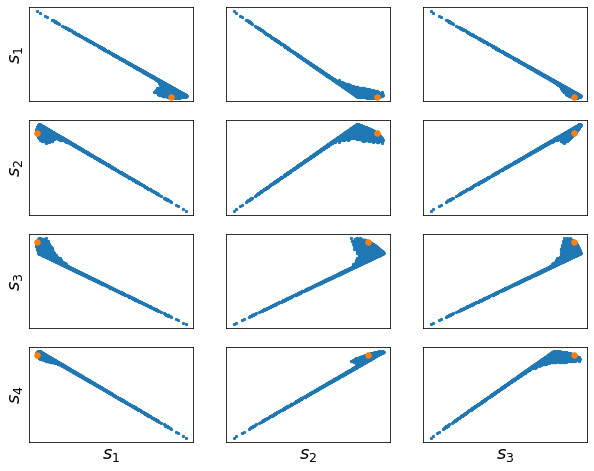

In [17]:
stat = list(permutations(range(4), 2))

plt.figure(figsize=(10, 8))
for i in range(len(stat)):
    plt.subplot(4, 3, i+1)
    plt.scatter(s_normal[:, stat[i][1]], s_normal[:, stat[i][0]], s=5)
    plt.scatter(s_obs_normal[0, stat[i][1]], s_obs_normal[0, stat[i][0]], s=30)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    if i%3==0:
        plt.ylabel("$s_{i}$".format(i=stat[i][0]+1), fontsize=18)
    if len(stat)-3 <= i < len(stat):
        plt.xlabel("$s_{i}$".format(i=stat[i][1]+1), fontsize=18, fontweight="bold")

# Robust

In [44]:
def solve_robust(beta):
    summary_net_robust = RickerSummary(1, 4).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(summary_net_robust.parameters(), lr=0.01)

    index_list = [int(i) for i in range(len(x))]

    num_epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in dataloader:
            inputs = data
            optimizer.zero_grad()

            outputs = summary_net_robust(inputs)

            random.shuffle(index_list)
            context_embeddings = torch.mean(summary_net_robust.forward_encoder(x[index_list[:200]]), dim=1)
            obs_embeddings = torch.mean(summary_net_robust.forward_encoder(obs_cont), dim=1)

            ae_loss = criterion(outputs, inputs) / 10000
            summary_loss = MMD_unweighted(context_embeddings, obs_embeddings, lengthscale=median_heuristic(context_embeddings))

            loss = ae_loss + beta*summary_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")
    return summary_net_robust

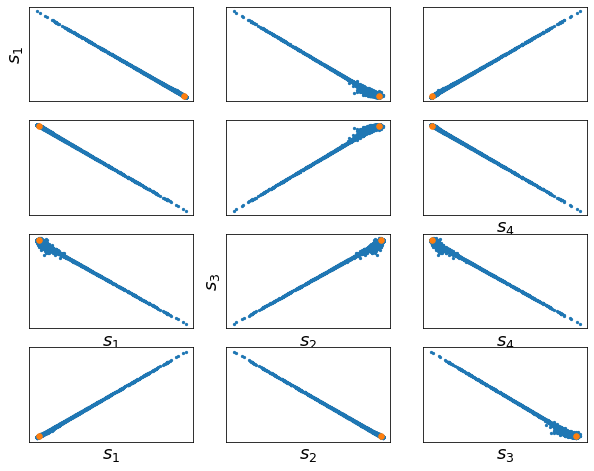

In [22]:
s_robust = torch.mean(summary_net_robust.forward_encoder(x).cpu(), dim=1).detach().numpy()
s_obs_robust = torch.mean(summary_net_robust.forward_encoder(obs_cont).cpu(), dim=1).detach().numpy()

stat = list(permutations(range(4), 2))
plt.figure(figsize=(10, 8))
for i in range(len(stat)):
    plt.subplot(4, 3, i+1)
    plt.scatter(s_robust[:, stat[i][1]], s_robust[:, stat[i][0]], s=5)
    plt.scatter(s_obs_robust[0, stat[i][1]], s_obs_robust[0, stat[i][0]], s=30)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    if i%7==0:
        plt.ylabel("$s_{i}$".format(i=stat[i][0]+1), fontsize=18)
    if len(stat)-7 <= i < len(stat):
        plt.xlabel("$s_{i}$".format(i=stat[i][1]+1), fontsize=18, fontweight="bold")


In [23]:
posterior_robust = regression_ABC(s_obs_robust, theta, s_robust, 0.05)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


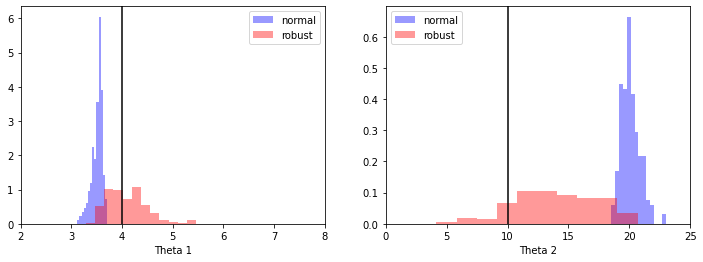

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(posterior_normal[:, 0], color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(posterior_robust[:, 0], color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
plt.xlim(2, 8)
plt.xlabel("Theta 1")

plt.subplot(1, 2, 2)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(posterior_normal[:, 1], color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(posterior_robust[:, 1], color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
plt.xlim(0, 25)
plt.xlabel("Theta 2")

plt.show()

In [25]:
RMSE(torch.tensor([4, 10]), torch.tensor(posterior_robust), 2)

tensor(3.6704, dtype=torch.float64)

In [26]:
RMSE(torch.tensor([4, 10]), torch.tensor(posterior_normal), 2)

tensor(7.1690, dtype=torch.float64)

In [59]:
n_sims = 50
beta = 4
for i in range(n_sims):
    print(f"Simulation {i}")
    summary_net_normal = solve_normal()
    s_normal = torch.mean(summary_net_normal.forward_encoder(x).cpu(), dim=1).detach().numpy()
    s_obs_normal = torch.mean(summary_net_normal.forward_encoder(obs_cont).cpu(), dim=1).detach().numpy()
    posterior_normal = regression_ABC(s_obs_normal, theta, s_normal, 0.05)
    
    summary_net_robust = solve_robust(beta)
    s_robust = torch.mean(summary_net_robust.forward_encoder(x).cpu(), dim=1).detach().numpy()
    s_obs_robust = torch.mean(summary_net_robust.forward_encoder(obs_cont).cpu(), dim=1).detach().numpy()
    posterior_robust = regression_ABC(s_obs_robust, theta, s_robust, 0.05)
    
    root_name = f'objects/ABC/ricker/lambda={beta}/' + str(i)
    if not os.path.exists(root_name):
        os.makedirs(root_name)
    np.save(root_name + '/posterior_normal.npy', posterior_normal)
    np.save(root_name + '/posterior_robust.npy', posterior_robust)

Simulation 0
Epoch 1, Loss: 15.757414531707763
Epoch 2, Loss: 12.344084882736206
Epoch 3, Loss: 12.036948084831238
Epoch 4, Loss: 11.987944746017456
Epoch 5, Loss: 11.974097740650176
Epoch 6, Loss: 11.967919993400574
Epoch 7, Loss: 11.965107250213624
Epoch 8, Loss: 11.963223993778229
Epoch 9, Loss: 11.96188156604767
Epoch 10, Loss: 11.960814702510834
Epoch 1, Loss: 16.107363367080687
Epoch 2, Loss: 12.85894775390625
Epoch 3, Loss: 12.691810393333435
Epoch 4, Loss: 12.663482880592346
Epoch 5, Loss: 12.642251682281493
Epoch 6, Loss: 12.634470820426941
Epoch 7, Loss: 12.624324369430543
Epoch 8, Loss: 12.614834570884705
Epoch 9, Loss: 12.604095602035523
Epoch 10, Loss: 12.583352279663085
Simulation 1
Epoch 1, Loss: 17.601317143440248
Epoch 2, Loss: 14.519493508338929
Epoch 3, Loss: 12.14720106124878
Epoch 4, Loss: 12.026547384262084
Epoch 5, Loss: 11.972477030754089
Epoch 6, Loss: 11.964013910293579
Epoch 7, Loss: 11.962104594707489
Epoch 8, Loss: 11.961442279815675
Epoch 9, Loss: 11.96041

Epoch 9, Loss: 12.59055438041687
Epoch 10, Loss: 12.593021440505982
Simulation 12
Epoch 1, Loss: 14.98644859790802
Epoch 2, Loss: 12.2268705368042
Epoch 3, Loss: 12.044648027420044
Epoch 4, Loss: 12.015044164657592
Epoch 5, Loss: 12.006688833236694
Epoch 6, Loss: 12.00097951889038
Epoch 7, Loss: 11.993408107757569
Epoch 8, Loss: 11.975891923904419
Epoch 9, Loss: 11.96465847492218
Epoch 10, Loss: 11.962047505378724
Epoch 1, Loss: 15.619908690452576
Epoch 2, Loss: 12.860547482967377
Epoch 3, Loss: 12.708851599693299
Epoch 4, Loss: 12.639389753341675
Epoch 5, Loss: 12.69611327648163
Epoch 6, Loss: 12.638553357124328
Epoch 7, Loss: 12.659758257865906
Epoch 8, Loss: 12.627895069122314
Epoch 9, Loss: 12.604948425292969
Epoch 10, Loss: 12.604906368255616
Simulation 13
Epoch 1, Loss: 16.049908804893494
Epoch 2, Loss: 12.311454558372498
Epoch 3, Loss: 12.03025450706482
Epoch 4, Loss: 11.981588196754455
Epoch 5, Loss: 11.972770714759827
Epoch 6, Loss: 11.96771764755249
Epoch 7, Loss: 11.96434118

Epoch 6, Loss: 12.655803203582764
Epoch 7, Loss: 12.63724751472473
Epoch 8, Loss: 12.62758297920227
Epoch 9, Loss: 12.607793283462524
Epoch 10, Loss: 12.621973729133606
Simulation 24
Epoch 1, Loss: 15.91462845802307
Epoch 2, Loss: 12.357334482669831
Epoch 3, Loss: 12.056288647651673
Epoch 4, Loss: 12.022422504425048
Epoch 5, Loss: 12.014151239395142
Epoch 6, Loss: 12.005486512184143
Epoch 7, Loss: 11.986430859565735
Epoch 8, Loss: 11.97276313304901
Epoch 9, Loss: 11.966370511054993
Epoch 10, Loss: 11.963915085792541
Epoch 1, Loss: 18.327082538604735
Epoch 2, Loss: 17.873541116714478
Epoch 3, Loss: 13.427008390426636
Epoch 4, Loss: 12.809801244735718
Epoch 5, Loss: 12.677671360969544
Epoch 6, Loss: 12.62507381439209
Epoch 7, Loss: 12.626714265346527
Epoch 8, Loss: 12.637580037117004
Epoch 9, Loss: 12.62632987499237
Epoch 10, Loss: 12.617735600471496
Simulation 25
Epoch 1, Loss: 14.536437273025513
Epoch 2, Loss: 12.114229941368103
Epoch 3, Loss: 11.994306063652038
Epoch 4, Loss: 11.97314

Epoch 4, Loss: 12.661621832847596
Epoch 5, Loss: 12.66265709400177
Epoch 6, Loss: 12.67582985162735
Epoch 7, Loss: 12.65170431137085
Epoch 8, Loss: 12.631843280792236
Epoch 9, Loss: 12.643597745895386
Epoch 10, Loss: 12.627249789237975
Simulation 36
Epoch 1, Loss: 15.324386990070343
Epoch 2, Loss: 12.19578001499176
Epoch 3, Loss: 12.054455876350403
Epoch 4, Loss: 12.028318309783936
Epoch 5, Loss: 12.009920001029968
Epoch 6, Loss: 12.002555513381958
Epoch 7, Loss: 11.9908616065979
Epoch 8, Loss: 11.978026723861694
Epoch 9, Loss: 11.968696689605713
Epoch 10, Loss: 11.963190579414368
Epoch 1, Loss: 16.140448331832886
Epoch 2, Loss: 12.823448657989502
Epoch 3, Loss: 12.697130107879639
Epoch 4, Loss: 12.665218496322632
Epoch 5, Loss: 12.648507738113404
Epoch 6, Loss: 12.646124649047852
Epoch 7, Loss: 12.629338765144348
Epoch 8, Loss: 12.597905993461609
Epoch 9, Loss: 12.606273078918457
Epoch 10, Loss: 12.62513039112091
Simulation 37
Epoch 1, Loss: 15.997341203689576
Epoch 2, Loss: 12.390902

Epoch 2, Loss: 13.135000109672546
Epoch 3, Loss: 12.760257387161255
Epoch 4, Loss: 12.689335215091706
Epoch 5, Loss: 12.655558037757874
Epoch 6, Loss: 12.652126598358155
Epoch 7, Loss: 12.64660153388977
Epoch 8, Loss: 12.64809055328369
Epoch 9, Loss: 12.642472314834595
Epoch 10, Loss: 12.629787731170655
Simulation 48
Epoch 1, Loss: 15.558352732658387
Epoch 2, Loss: 12.321665382385254
Epoch 3, Loss: 12.052509593963624
Epoch 4, Loss: 12.01957677602768
Epoch 5, Loss: 12.003397071361542
Epoch 6, Loss: 11.982561326026916
Epoch 7, Loss: 11.971551382541657
Epoch 8, Loss: 11.965462040901183
Epoch 9, Loss: 11.962927281856537
Epoch 10, Loss: 11.962343502044678
Epoch 1, Loss: 18.33980016708374
Epoch 2, Loss: 14.819771003723144
Epoch 3, Loss: 12.907447671890258
Epoch 4, Loss: 12.686687994003297
Epoch 5, Loss: 12.640880894660949
Epoch 6, Loss: 12.645299887657165
Epoch 7, Loss: 12.641409230232238
Epoch 8, Loss: 12.63719732761383
Epoch 9, Loss: 12.628907418251037
Epoch 10, Loss: 12.607009530067444
Si

In [62]:
beta = 2
rmse_normal = np.zeros(n_sims)
rmse_robust = np.zeros(n_sims)
for i in range(n_sims):
    root_name = root_name = f'objects/ABC/ricker/lambda={beta}/' + str(i)
    posterior_normal = torch.tensor(np.load(root_name + '/posterior_normal.npy'))
    posterior_robust = torch.tensor(np.load(root_name + '/posterior_robust.npy'))
    rmse_normal[i] = RMSE(torch.tensor([4, 10]), posterior_normal, 2)
    rmse_robust[i] = RMSE(torch.tensor([4, 10]), posterior_robust, 2)

print("RMSE mean for normal model: ", np.mean(rmse_normal))
print("RMSE mean for robust model: ", np.mean(rmse_robust))
print("RMSE std for normal model: ", np.std(rmse_normal))
print("RMSE std for robust model: ", np.std(rmse_robust))

RMSE mean for normal model:  6.850179954141015
RMSE mean for robust model:  3.9267764210600635
RMSE std for normal model:  0.23192051706250236
RMSE std for robust model:  1.2698520633154387
